# Gradient Descent

In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
# import libraries
import numpy as np
import matplotlib as mp
import pandas as pd
import matplotlib.pyplot as plt
import laUtilities as ut
import slideUtilities as sl
import pandas as pd
from importlib import reload
from datetime import datetime
from IPython.display import Image
from IPython.display import display_html
from IPython.display import display
from IPython.display import Math
from IPython.display import Latex
from IPython.display import HTML
from typing import List, Tuple, Dict, Set, Union
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.animation import FuncAnimation
from matplotlib import rc

import slideUtilities as sl


np.random.seed(12345)
print('')

In [2]:
%%html
<style>
 .container.slides .celltoolbar, .container.slides .hide-in-slideshow {
    display: None ! important;
}
</style>

%Set up useful MathJax (Latex) macros.
%See http://docs.mathjax.org/en/latest/tex.html#defining-tex-macros
%These are for use in the slideshow
$\newcommand{\mat}[1]{\left[\begin{array}#1\end{array}\right]}$
$\newcommand{\vx}{{\mathbf x}}$
$\newcommand{\hx}{\hat{\mathbf x}}$
$\newcommand{\vbt}{{\mathbf\beta}}$
$\newcommand{\vy}{{\mathbf y}}$
$\newcommand{\vz}{{\mathbf z}}$
$\newcommand{\R}{{\mathbb{R}}}$
$\newcommand{\vu}{{\mathbf u}}$
$\newcommand{\vv}{{\mathbf v}}$
$\newcommand{\vw}{{\mathbf w}}$
$\newcommand{\col}{{\operatorname{Col}}}$
$\newcommand{\nul}{{\operatorname{Nul}}}$
$\newcommand{\vb}{{\mathbf b}}$
$\newcommand{\va}{{\mathbf a}}$
$\newcommand{\ve}{{\mathbf e}}$
$\newcommand{\setb}{{\mathcal{B}}}$
$\newcommand{\rank}{{\operatorname{rank}}}$
$\newcommand{\vp}{{\mathbf p}}$

Lets revisit Linear Regression.

We were given feature matrix $\textbf{X}\in\mathbb{R}^{n\times m}$ and ground truth vector $\textbf{y}\in \mathbb{R}^{n\times 1}$ and we wanted to learn the parameters $\mathbf{\beta}\in \mathbb{R}^{m\times 1}$ that created the "best" fitting line $\hat{\textbf{y}} = \textbf{X}\mathbf{\beta} + \beta_0$.

First, we rewrote the expression of our line to be $\hat{\textbf{y}} = [\textbf{1}, \textbf{X}]\mathbf{\beta}$ for conveniece.

We then decided that we were going to measure the "best" fitting line to be the line that minimized the squared sum of __residuals__ (i.e. the sum of the difference between what the model predicted and the ground truth).

Formally, we are looking for:

$\mathbf{\beta}^* = arg\min\limits_{\mathbf{\beta}\in \mathbb{R}^{(m+1)\times 1}} \sum\limits_{i=1}^{n} (\hat{\textbf{y}}_i - \textbf{y}_i)^2 = arg\min\limits_{\mathbf{\beta}\in \mathbb{R}^{(m+1)\times 1}} ||\hat{\textbf{y}} - \textbf{y}||_2^2$

and we found out that we can compute this directly (i.e. there is a __closed form__ solution):

$\mathbf{\beta}^* = \mathbf{X}^\dagger \textbf{y}$ where $\textbf{X}^\dagger$ is the __psuedoinverse__ of $\textbf{X}$ and can be defined as $\textbf{X}^\dagger = (\textbf{X}^T\textbf{X})^{-1}\textbf{X}^T$

Great! This is __fantastic__, it is rare to get a closed form solution, so when we do, we should be very happy!

There is just one caviat though, and it is a big one. We can only used this closed form solution if $\textbf{X}^T\textbf{X}$ is invertible. What happens if $\textbf{X}^T\textbf{X}$ is singular?

Solution: we need a different optimization method.

## Motivation for Gradient Descent

Lets think about what is happening to the loss of the model as the different parameters change value. After all, we are computing $$\mathbf{\beta}^* = arg\min\limits_{\mathbf{\beta}\in \mathbb{R}^{(m+1)\times 1}} \sum\limits_{i=1}^{n} (\hat{\textbf{y}}_i - \textbf{y}_i)^2$$ so lets iterate over all possible values of $\mathbf{\beta}$ and see what happens to the error if we used that $\beta$ for the parameters in our linear regression model

Here is a small plot of this "error surface" for some dummy data in 2d (i.e. 2 parameters):

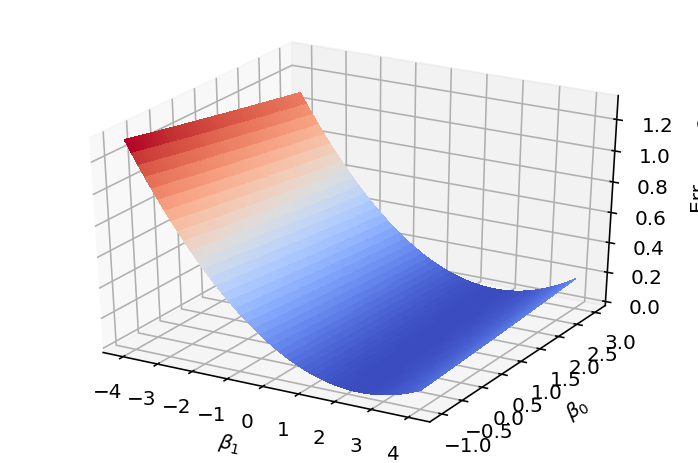

In [208]:
x: np.ndarray = np.arange(0, 10, 0.01)
y_ground_truth: np.ndarray = 2*x + 1

# predict linear regression model given parameter settings
def linear_regression(x: np.ndarray, beta0: float, beta1: float) -> np.ndarray:
    return beta1*x + beta0

# lets evaluate the performance of the linear regression model at all of these parameters values
beta0s, beta1s = np.meshgrid(np.arange(-1, 3+0.01, 0.01), np.arange(-4, 4+0.01, 0.01))

# side note: there is a MUCH faster way to do this, but I don't want to pull out
# numpy tricks if it becomes much more confusing to follow along
errors: List[float] = list()
for beta0, beta1 in zip(beta0s.reshape(-1), beta1s.reshape(-1)):
        errors.append(np.linalg.norm(linear_regression(x, beta0, beta1)-y_ground_truth, ord=2)**2)
errors = np.array(errors, dtype=float).reshape(beta0s.shape)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(beta1s, beta0s, Z=errors, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.set_xlabel(r"$\beta_1$")
ax.set_ylabel(r"$\beta_0$")
ax.set_zlabel("Err", rotation=90)
plt.show()

Of course, we only got such a pretty picture because I centered the plot around the "optimal" values for $\beta_0$ and $\beta_1$ (because I knew them beforehand). However, this will not likely be the case given a random dataset, and besides, it would be computationally infeasible to check every parameter combination, especially when the number of parameters grows!

What we need is a way to __explore__ this error (or "loss") surface, and decide, given the __current__ parameter combination, what the __next__ parameter combination should be. Ideally, the __next__ parameter combination should do at least as good as the __current__ parameter combination (for iteration $t$):

$$\sum\limits_{i=1}^{n} (f(\textbf{x}_i, \mathbf{\beta}_{t+1}) - \textbf{y}_i)^2 \le \sum\limits_{i=1}^{n} (f(\textbf{x}_i, \mathbf{\beta}_t) - \textbf{y}_i)^2$$

where $f(\cdot, \cdot)$ is the function we are learning. In the case of linear regression, it is $f(\textbf{x}_i, \beta) = [1,\textbf{x}_i]\beta$ 

Lets make the algorithm a little bit simpler. Lets say that we are currently at $\beta_t$. What we are going to do is compute the next parameter combination $\beta_{t+1}$ by taking a "step" from $\beta_t$:

$$\beta_{t+1} = \beta_t + \eta\cdots$$
where $\eta$ is a hyperparameter (i.e. a constant decided __before__ training) that tells us the step size (i.e. how far away will $\beta_{t+1}$ be from $\beta_t$.

This means that the $\cdots$ in our equation above should be a __direction__. Think of it this way: imagine you are standing on the street and you cannot see. You also have the ability to measure exactly how far of a step you will take, and your goal is to move to the lowest point on the street. Since you know your current position, and how far you can move, to get to the lowest position, the only thing you do __not__ know yet (that you need to know) is the direction towards the lowest point on the street.

## The Game

### Setting:
Imagine you are standing on a mountain and you cannot see. You have the ability to measure exactly how far of a step you will take.
### GOAL:
Move to the lowest point on the mountain.

### What do you do?

### Solution?
What if we feel the "slope" of the mountain and move downhill? To be cautious, lets only take small steps so we don't miss any sudden changes in elevation.

Side note: The slope of the mountain tells us the __direction__ we should be moving, and our step size tells us the __magnitude__ of the step.

## A Dip in Calculus

How do we feel slope? Mathematically, this is called a __gradient__ ($\nabla$), which is a vector of partial derivatives.

For us, we want to feel the slope of the __error surface__, and we want to __adjust our parameters__. This means that our partial derivatives will be (the derivative of) the error function $\mathbb{E}[L]$, with respect to our learnable parameters: 
$$\nabla \mathbb{E}[L(\textbf{x}_i, \beta, y_i)] = \Big[\frac{\partial \mathbb{E}[L(\textbf{x}_i, \beta, y_i)]}{\partial \beta_1}, \frac{\partial \mathbb{E}[L(\textbf{x}_i, \beta, y_i)]}{\partial \beta_2}, \dots, \frac{\partial \mathbb{E}[L(\textbf{x}_i, \beta, y_i)]}{\partial \beta_{m+1}}\Big]$$

Lets take a step back. Consider single variable functions $y = f(x)$. The derivative $\frac{df(x)}{dx}$ tells us the __slope__ of the function. Most importantly, $\frac{df(x)}{dx}$ always tells us the __direction__ that points in the direction of a __local max__ of $f(x)$.

Don't believe me? I'll show you. Lets conceptually do the __exact same thing__ we are trying to do for our learnable parameters, but in a 1-dimensional case. Below is a code snippet that generates a function $f(x)$, then randomly chooses $x_0$, and updates it to $x_1$, then updates it againt to $x_2$, $\dots$. The whole time, the point $y_t = f(x_t)$ will get closer to the local max of $f(x)$:

In [9]:
# y = f(x)
def f(x: np.ndarray) -> np.ndarray:
    return -(x**2)

# make some data
x: np.ndarray = np.arange(-3, 3+0.01, 0.01)
y: np.ndarray = f(x)

# we know how to compute the derivative of f(x) from calculus!
def df_dx(x: float) -> float:
    return -2*x


In [20]:
# choose a random point
x: np.ndarray = np.arange(-10,10,0.01)
y: np.ndarray = f(x)
x_t: float = np.random.uniform(low=-10, high=10) #low=-3, high=3)

# stop the process when we "converge." We will define convergence just like we did
# with the power method....keep going until the new point and the old point
# are really close together, only this time, we will use "percent relative error"
# instead of the l-2 norm
epsilon: float = 1e-9
delta: float = 1

# how big of a step are we taking?
eta: float = 0.1

# collect all the x_t points as we go, so we can plot them later
x_ts: List[float] = [x_t]

# only run this algorithm for max 5 times unless it converges otherwise (safety)
t_max: int = 5
t: int = 0
while delta > epsilon and t < t_max:
    x_t_plus_1: float = x_t + eta*df_dx(x_t)
    x_ts.append(x_t_plus_1)

    delta = abs(x_t_plus_1-x_t)/abs(x_t)
    x_t = x_t_plus_1
    t += 1

# convert x_ts to numpy & get corresponding y_t values
x_ts = np.array(x_ts, dtype=float)
y_ts: np.ndarray = f(x_ts)
    
print(x_ts)

[9.29029039 7.43223232 5.94578585 4.75662868 3.80530295 3.04424236]


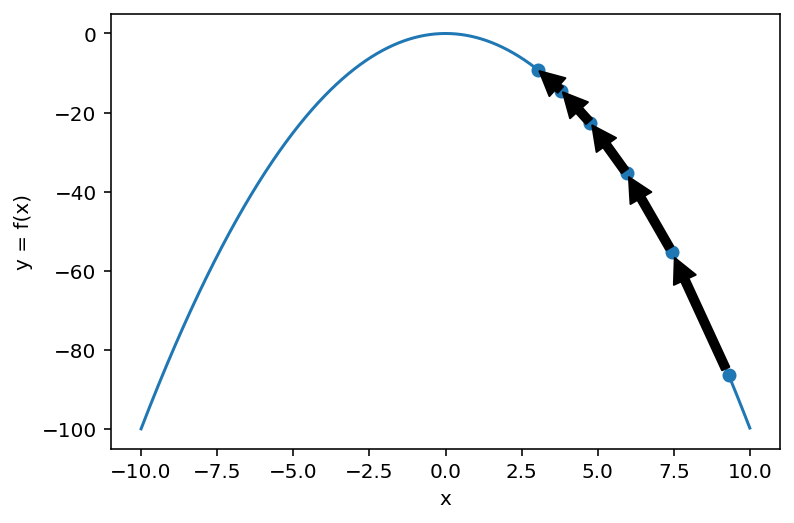

In [21]:
plt.plot(x, y)
plt.scatter(x_ts, y_ts)

# draw arrows between each point showing how it changed
for t in range(1, x_ts.shape[0]):
    plt.annotate("", xytext=(x_ts[t-1], y_ts[t-1]), xy=(x_ts[t], y_ts[t]),
                 arrowprops={'facecolor':'black', 'shrink':0.05})
plt.xlabel("x")
plt.ylabel("y = f(x)")
plt.show()

Great! So, if we want to get to a __minimum__, we need to move in the direction of $-\frac{df(x)}{dx}$. One thing to note here is that our initial position __matters__, because the derivative moves in the direction of a __local__ maximum. We got lucky that our function was convex (i.e. has only a global optima), and that our global optima was a global maximum. Lets see what happens with $f(x) = sin(x)$ as we vary our initial guess, and this time we will try to find local __minima__ using $-\frac{df(x)}{dx}$:

In [212]:
def f(x: np.ndarray) -> np.ndarray:
    return np.sin(8*x/np.pi)

x: np.ndarray = np.arange(0, 2*np.pi, 0.01)
y: np.ndarray = f(x)

# df(x)/dx
def df_dx(x: float) -> float:
    return (8/np.pi)*np.cos(8*x/np.pi) # derivative of sin(ax) = a*cos(ax)


# same algorithm as above, but made into a function so we can repeat it for multiple initial positions
def find_local_min(x_0: float, eta: float, epsilon: float=1e-9, t_max: int=5) -> Tuple[np.ndarray, np.ndarray]:
    delta: float = 1

    x_ts: List[float] = [x_0]
    x_t: float = x_0

    t: int = 0
    while delta > epsilon and t < t_max:
        x_t_plus_1: float = x_t - eta*df_dx(x_t) # x_{t+1} = x_t - eta*df(x)/dx to find local min
        x_ts.append(x_t_plus_1)

        delta = abs(x_t_plus_1-x_t)/abs(x_t)
        x_t = x_t_plus_1
        t += 1

    x_ts = np.array(x_ts, dtype=float)
    y_ts: np.ndarray = f(x_ts)
    return x_ts, y_ts

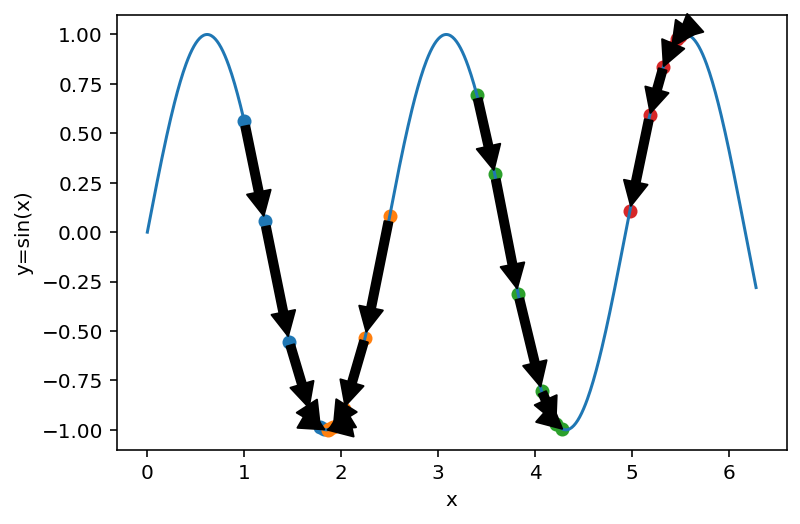

In [213]:
x1s, y1s = find_local_min(1, 0.1)
x2s, y2s = find_local_min(2.5, 0.1)
x3s, y3s = find_local_min(3.4, 0.1)
x4s, y4s = find_local_min(5.5, 0.1)

plt.plot(x, y)
for x_ts, y_ts in zip([x1s, x2s, x3s, x4s], [y1s, y2s, y3s, y4s]):
    plt.scatter(x_ts, y_ts)

    # draw arrows between each point showing how it changed
    for t in range(1, x_ts.shape[0]):
        plt.annotate("", xytext=(x_ts[t-1], y_ts[t-1]), xy=(x_ts[t], y_ts[t]),
                     arrowprops={'facecolor':'black', 'shrink':0.05})

plt.xlabel("x")
plt.ylabel("y=sin(x)")
plt.show()

## Gradient, Jacobian, and the Gradient Descent Algorithm

Ok, onto the multidimensional case.

Let us say we have $z = f(x, y)$. If we want to compute the "derivative" here, we have to be more specific. Compute the derivative with respect to which variable? We now have more than one choice (i.e. $x$ or $y$). We denote the choice here by saying $\frac{\partial f(x,y)}{\partial x}$, which formally is computing the derivative with respect to $x$ while keeping __every other variable constant__. This is called a __partial derivative__.

What we __want__ to do is measure "how the error is changing as a function of each learnable parameter," which translates into $\frac{\partial \mathbb{E}[L(x_1, x_2, \dots, x_n)]}{\partial x_1}, \frac{\partial \mathbb{E}[L(x_1, x_2, \dots, x_n)]}{\partial x_2}, \dots, \frac{\partial \mathbb{E}[L(x_1, x_2, \dots, x_m)]}{\partial x_m}$ where $x_1, x_2, \dots, x_m$ are the learnable parameters, and the function $e = \mathbb{E}[L]$ is the error function of our model.

Fortunatley,  there is an operator $\nabla = [\frac{\partial}{\partial x_1}, \frac{\partial}{\partial x_2}, \dots, \frac{\partial}{\partial x_m}]$. Great! If we apply this to $e$, we get the vector:
$$\nabla e(x_1, x_2, \dots, x_m) = \Big[\frac{\partial e(x_1, x_2, \dots, x_m)}{\partial x_1}, \frac{\partial e(x_1, x_2, \dots, x_m)}{\partial x_2}, \dots, \frac{\partial e(x_1, x_2, \dots, x_m)}{\partial x_m}\Big]$$

This is called the __gradient__ of $e$, and just like the 1-d case, each element of the __gradient__ points in the direction towards the local max of $e$ keeping all other variables constant (i.e. $\frac{\partial e}{\partial x_1}$ points in the direction of the local max of $e$ if we are only allowed to change $x_1$ and variables $x_2, \dots, x_m$ are held constant.

So what will we do? For each training pair in our data, compute the __gradient__ of our error with respect to each learnable parameter, and then update all our parameters at once until we converge.

When we compute all of the gradients for each sample, we are computing what is called the __Jacobian__ matrix $\textbf{J}$. Formally, the Jacobian matrix is defined as:

$$\textbf{J}(\textbf{X}, \textbf{y}, \beta) = \mat{{c}\nabla e(\textbf{x}_1, y_1, \beta)\\ \vdots\\ \nabla e(\textbf{x}_n, y_n, \beta)} = \mat{{ccc}\frac{\partial e(\textbf{x}_1, y_1, \beta)}{\partial \beta_1} & \dots & \frac{\partial e(\textbf{x}_1, y_1, \beta))}{\partial \beta_{m+1}}\\ \vdots & \ddots & \vdots\\ \frac{\partial e(\textbf{x}_n, y_n, \beta)}{\partial \beta_1} & \dots & \frac{\partial e(\textbf{x}_n, y_n, \beta)}{\partial \beta_{m+1}}}$$
which can be thought of as "row $i$ of the jacobian is the gradient of example $i$ with respect to $\beta$."

Once the jacobian matrix is computed, we sum over the columns to compute the overall direction to move in parameter space. Think of this as giving each example in our dataset an equal vote on which direction to update the parameters. When we sum them all together, we are computing the direction the parameters should move in in order to do better on the entire dataset __overall__.

Therefore, our update rule will be like this:
$$\beta_{t+1} = \beta_t - \eta\textbf{1}^T\textbf{J}(\textbf{X}, \textbf{y}, \beta_t)$$

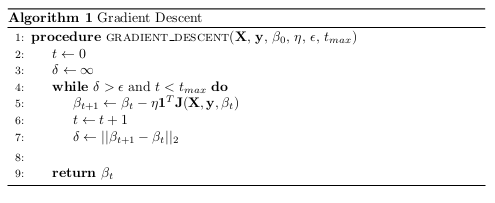

In [32]:
sl.hide_code_in_slideshow()
display(Image("figs/gd.png", width=650))

## Gradient Descent Example (Linear Regression)

Lets compute this rule for training our linear regression model from earlier, but we have some work to do.

We need to compute the jacobian of our linear regression model first, before we can write the code. From calculus, we can use the __chain rule__ to break up computing the jacobian into smaller, bite-size chunks that we can translate into code (and then have plug-n-play behavior).

The __chain rule__ in the single variable case, works like this:
$$\frac{df(g(x))}{dx} = \frac{df(g(x))}{dg(x)}\frac{dg(x)}{dx} = f'(g(x))g'(x)$$

The reason this is so helpful for us is because it means we can split up computing each gradient (which is a composition of functions) into the product of gradients. In other words, we can split up our linear regression gradients from:

$$\frac{\partial e(\textbf{X}, \textbf{y}, \beta)}{\partial \beta_j}=\frac{\sum\limits_{k=1}^n (\hat{y}_k-y_k)^2}{\partial \beta_j}$$

into:
$$\frac{\partial e(\textbf{X}, \textbf{y}, \beta)}{\partial \hat{y}_i}\frac{\partial \hat{y}_i}{\partial \beta_j} = \frac{\sum\limits_{k=1}^n (\hat{y}_k-y_k)^2}{\partial \hat{y}_i}\frac{\partial \hat{y}_i}{\partial \beta_j}$$

Awesome! This is huge: not only does this make computing the overall gradient easier (by splitting it up into separate terms), but this makes our algorithm easier too! Why? Each term in our jacobian will have a $$\frac{e(\textbf{X}, \textbf{y}, \beta)}{\partial \hat{y}_i}$$ term in it (for different $i$), so if we compute $\nabla e(\textbf{X}, \textbf{y}, \beta)$ (with respect to each $\hat{y}_i$), we can __cache__ this information and won't have to recompute it!

Lets start with the gradient of the error function: $\nabla e(\textbf{X}, \textbf{y}, \beta)$ for a particular $\hat{y}_i$.

We know the derivative of a sum is the sum of derivatives. Lets apply that:
$$\frac{\sum\limits_{k=1}^n (\hat{y}_k-y_k)^2}{\partial \hat{y}_i} = \sum\limits_{k=1}^n \frac{\partial (\hat{y}_k-y_k)^2}{\partial \hat{y}_i}$$

Cool. Since we are taking the partial derivative with respect to a __particular__ $\hat{y}_i$, the partial derivative when $k \ne i$ is zero:
$$\sum\limits_{k=1}^n \frac{\partial (\hat{y}_k-y_k)^2}{\partial \hat{y}_i} = \frac{\partial(\hat{y}_i-y_i)^2}{\partial \hat{y}_i}$$

Now we can compute this partial derivative directly:
$$\frac{\partial(\hat{y}_i-y_i)^2}{\partial \hat{y}_i} = 2(\hat{y}_i - y_i)$$

Cool, so this means the gradient $\nabla e(\textbf{X}, \textbf{y}, \beta) = 2\Big[\hat{y}_1-y_1, \dots, \hat{y}_n-y_n\Big]$

Alright, lets work now on $\frac{\partial\hat{y}_i}{\partial \beta_j}$.

We know $\hat{y}_i = \textbf{z}_i\beta$ (remember, $\textbf{z}_i = \Big[1,\textbf{x}_i\Big]^T$ is a __row__ vector)

Cool. We can express this as: $\sum\limits_{k=1}^n z_{i,k}\beta_k$
Again, remember that the derivative of a sum is the sum of derivatives:
$$\frac{\partial\hat{y}_i}{\partial \beta_j} = \frac{\partial\sum\limits_{k=1}^n z_{i,k}\beta_k}{\partial \beta_j} = \sum\limits_{k=1}^n \frac{\partial z_{i,k}\beta_k}{\partial \beta_j}$$

This partial derivative is 0 when $k \ne j$, and $z_{i,k}$ when $k == j$. Therefore:
$$\frac{\partial\hat{y}_i}{\partial \beta_j} = \sum\limits_{k=1}^n \frac{\partial z_{i,k}\beta_k}{\partial \beta_j} = z_{i,j}$$

So the gradient $\nabla \hat{y}_i = \textbf{z}_i$

Almost done! The last thing we can do is to vectorize these calculations:

For the entire dataset $\textbf{X}, \textbf{y}$, remember, we want to compute the jacobian:
$$\textbf{J} = \mat{{ccc}\frac{\partial e(\textbf{x}_1, y_1, \beta)}{\partial \beta_1} & \dots & \frac{\partial e(\textbf{x}_1, y_1, \beta))}{\partial \beta_{m+1}}\\ \vdots & \ddots & \vdots\\ \frac{\partial e(\textbf{x}_n, y_n, \beta)}{\partial \beta_1} & \dots & \frac{\partial e(\textbf{x}_n, y_n, \beta)}{\partial \beta_{m+1}}}$$

Plugging in the chain rule, we can see:
$$\textbf{J} = \mat{{ccc}\frac{\partial e}{\partial \hat{y}_1}\frac{\partial \hat{y}_1}{\beta_1} & \dots & \frac{\partial e}{\partial \hat{y}_1}\frac{\partial \hat{y}_1}{\beta_{m+1}}\\ \vdots & \ddots & \vdots\\ \frac{\partial e}{\partial \hat{y}_n}\frac{\partial \hat{y}_n}{\partial \beta_1} & \dots & \frac{\partial e}{\partial \hat{y}_n}\frac{\partial \hat{y}_n}{\partial \beta_{m+1}}}$$

Plugging in our knowledge of $\frac{\partial \hat{y}_i}{\partial \beta_j} = z_{i,j}$, we get:
$$\textbf{J} = \mat{{ccc}\frac{\partial e}{\partial \hat{y}_1}z_{1,1} & \dots & \frac{\partial e}{\partial \hat{y}_1}z_{1,m+1}\\ \vdots & \ddots & \vdots\\ \frac{\partial e}{\partial \hat{y}_n}z_{n,1} & \dots & \frac{\partial e}{\partial \hat{y}_n}z_{n,m+1}}$$

Eventually, we are going to sum along each column to compute the overall gradient, so it would be really nice __not__ to compute the jacobian directly. Fortunatley, we can avoid doing so with this expression:
$$\textbf{Z}^T\nabla e(\hat{\textbf{y}}, \textbf{y}) = \mat{{ccc}z_{1,1} & \dots & z_{n,1}\\ \vdots & \ddots & \vdots\\ z_{1,m+1}& \dots& z_{n,m+1}}\mat{{c} \frac{\partial e}{\partial \hat{y}_1}\\ \vdots\\ \frac{\partial e}{\partial \hat{y}_n}}$$

This matrix multiplication will compute the column sum of the jacobian. Sweet! Saves us time and effort!

Here is the code to train a linear regression model via gradient descent

In [12]:
# our sum of squared error
class SSE(object):
    def __init__(self) -> None:
        ...

    # __call__ methods lets us call objects like functions
    def __call__(self, Y_hat: np.ndarray, Y_gt: np.ndarray) -> float:
        return np.sum((Y_hat - Y_gt)**2)

    def gradient(self, Y_hat: np.ndarray, Y_gt: np.ndarray) -> np.ndarray:
        return 2*(Y_hat - Y_gt) # gradient e(X,y,beta)...this will return a matrix of the differences


In [13]:
class LinearRegression(object):
    def __init__(self, num_features: int) -> None:
        self.beta: np.ndarray = np.random.randn(num_features+1, 1)
        self.error_func: object = SSE()

    def predict(self, X: np.ndarray) -> np.ndarray:
        Z: np.ndarray = np.hstack([X, np.ones((X.shape[0], 1), dtype=float)])
        return np.dot(Z, self.beta)

    # typically you would write a "fit" method that would handle converging,
    # but we're going to manually do that so we can plot performance, learned function, etc.
    def fit_one_iteration(self, X: np.ndarray, y: np.ndarray, eta: float) -> np.ndarray:
        Z: np.ndarray = np.hstack([X, np.ones((X.shape[0], 1), dtype=float)])
        dyhat_dbeta: np.ndarray = Z.T

        y_hat: np.ndarray = self.predict(X)

        derror_dyhat: np.ndarray = self.error_func.gradient(y_hat, y)
        derror_dbeta: np.ndarray = np.dot(dyhat_dbeta, derror_dyhat) # Z.T * grad error

        # take the step in whatever direction our gradient is telling us
        self.beta = self.beta - eta*derror_dbeta
        return self.beta


In [14]:
# make up some data....target function is 2*x + 1
X: np.ndarray = np.arange(0, 100+1, 1).reshape(-1, 1)
y_gt: np.ndarray = 2 * X + 1

m: LinearRegression = LinearRegression(num_features=X.shape[-1])

# plot error surface (x and y coordinates here)
beta1s: np.ndarray = np.arange(-4, 4+0.1, 0.01)
beta0s: np.ndarray = np.arange(-4, 4+0.1, 0.01)
beta1s, beta0s = np.meshgrid(beta1s, beta0s)

# z coordinates for our error surface
errors: List[float] = list()
for beta1, beta0 in zip(beta1s.reshape(-1), beta0s.reshape(-1)):
    m.beta = np.array([beta1, beta0]).reshape(-1,1) # make it a column vector
    errors.append(m.error_func(m.predict(X), y_gt))
errors = np.array(errors, dtype=float).reshape(beta1s.shape)

In [15]:
# start beta at a point and iteratively apply gradient descent
m.beta = np.array([-3.5, -3.5]).reshape(-1,1)

# update 1,000,000 times
num_training_iter: int = int(1e6)

# learning rate is super low because the gradients are really large (watch out for this!!)
# typically better to work with MSE instead of SSE because of numerical stability
eta: float = 1e-7

# keep track of our trajectory along the loss surface
errors_t: List[float] = [m.error_func(m.predict(X), y_gt)]
betas_t: List[np.ndarray] = [m.beta.reshape(-1)]

# do the training
for t in range(num_training_iter):
    betas_t.append(m.fit_one_iteration(X, y_gt, eta).reshape(-1))
    errors_t.append(m.error_func(m.predict(X), y_gt))
betas_t = np.array(betas_t)
errors_t = np.array(errors_t)
trajectory: np.ndarray = np.hstack([betas_t, errors_t.reshape(-1,1)])

# what was our final parameters? If we train long enough, should converge to [2, 1]
print(m.beta.reshape(-1))

[2.00039233 0.97371619]


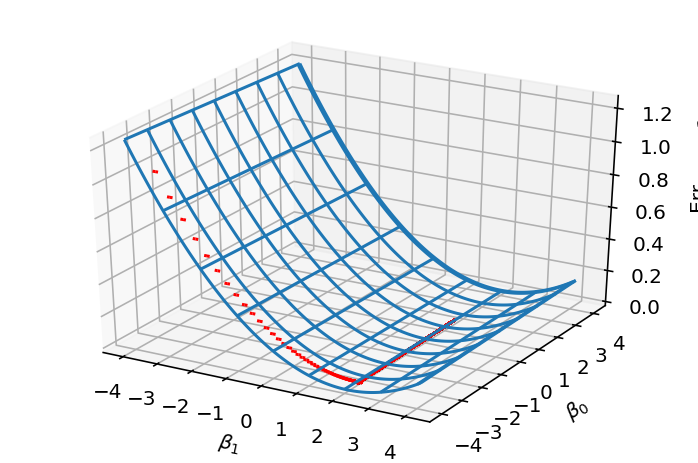

In [16]:
# make arrow data (x,y,z) -> (dx, dy, dz)
arrow_dirs: np.ndarray = trajectory[1:,:] - trajectory[:-1,:]

fig = plt.figure()
ax = fig.add_subplot(1,1,1, projection="3d")

# loss surface as wireframe
ax.plot_wireframe(beta1s, beta0s, Z=errors, rstride=100, cstride=100)

# this is how you make 3d arrows
ax.quiver(trajectory[:-1,0], trajectory[:-1,1], trajectory[:-1,2], arrow_dirs[:,0], arrow_dirs[:,1],
          arrow_dirs[:,2], normalize=True, color="red")
ax.set_xlabel(r"$\beta_1$")
ax.set_ylabel(r"$\beta_0$")
ax.set_zlabel("Err", rotation=90)
plt.show()

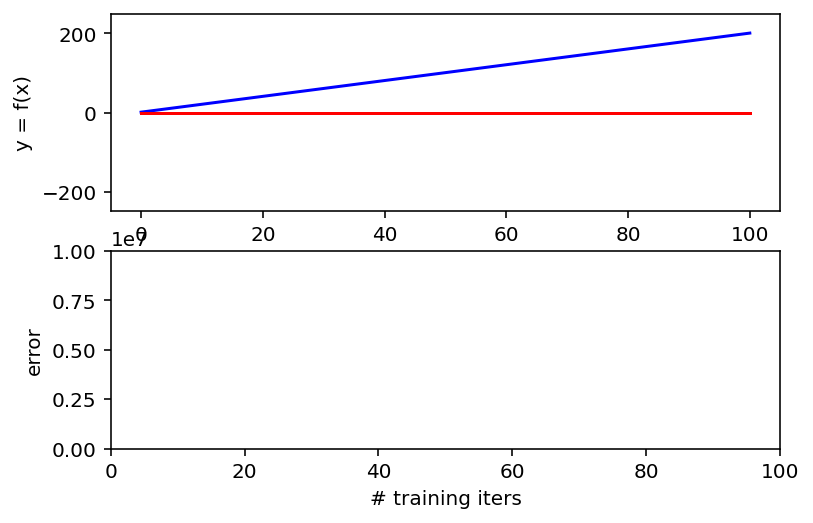

In [17]:
# lets make an animation of the model learning the trajectory
# we just plotted on the loss surface...first reset model parameters
m.beta = np.array([-3.5, -3.5]).reshape(-1,1)

# make this way smaller for memory purposes
num_training_iter: int = 100

# gonna have 2 figures...top one will be the function we learned
# bottom one will be error vs. training iteration
fig = plt.figure(1)
ax1 = fig.add_subplot(2,1,1)
ax1.set_ylim(-250, 250)
gt_func, = ax1.plot(X.reshape(-1), 2*X.reshape(-1)+1, c="b")
lr_func, = ax1.plot(X.reshape(-1), 0*X.reshape(-1), c="r")
ax1.set_xlabel("x")
ax1.set_ylabel("y = f(x)")
ax.set_title("training iteration 0 error 0")

ax2 = fig.add_subplot(2,1,2)
ax2.set_xlim(0, num_training_iter)
ax2.set_ylim(0, int(1e7))
ax2.set_xlabel("# training iters")
ax2.set_ylabel("error")
ln, = ax2.plot([0], [0], "b")

In [18]:
training_iters: List[int] = list()
errors: List[float] = list()

def init_frame_func() -> None:
    gt_func, = ax1.plot(X.reshape(-1), 2*X.reshape(-1)+1, c="b")
    ln, = ax2.plot([0], [0], "b")
    return gt_func, lr_func, ln,


def frame_update_func(t: int) -> None:
    global training_iters, errors
    m.fit_one_iteration(X, y_gt, eta)
    e: float = m.error_func(m.predict(X), y_gt)
    errors.append(e)
    lr_func.set_ydata(m.predict(X).reshape(-1))
    ax1.set_title("training iter {0:.3f} error {1:.3f}".format(t+1, e))

    training_iters.append(t)
    ln.set_data(training_iters, errors)
    return gt_func, lr_func, ln,

ani = FuncAnimation(fig, frame_update_func, init_func=init_frame_func,
                    frames=range(num_training_iter), repeat=True, blit=True)
HTML(ani.to_html5_video())